---
### Includes

In [1]:
%matplotlib inline

import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

from IPython import display
plt.ion()

# if gpu is to be used
device = torch.device("cuda")

In [22]:
from cartpole import CartPoleEnv
env = CartPoleEnv(False)

In [17]:
env.vel_threshold

48.0

---
### Helper functions

In [4]:
def plot_durations(episode_durations):
    fig, axs = plt.subplots(2, figsize=(10,10))
    
    durations_t, durations = list(map(list, zip(*episode_durations)))
    durations = torch.tensor(durations, dtype=torch.float)
    
    fig.suptitle('Training')
    axs[0].set_xlabel('Episode')
    axs[0].set_ylabel('Reward')
    
    axs[0].plot(durations_t, durations.numpy())
        
    plt.pause(0.001)  # pause a bit so that plots are updated
    display.clear_output(wait=True)

---
### Code

In [5]:
# (state, action) -> (next_state, reward, done)
transition = namedtuple('transition', ('state', 'action', 'next_state', 'reward', 'done'))

# replay memory D with capacity N
class ReplayMemory(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    # implemented as a cyclical queue
    def store(self, *args):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        
        self.memory[self.position] = transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [6]:
def plot_norms(episode_durations):
    plt.figure(2, figsize=(10,10))
    
    x, ys = np.array(list(episode_durations.keys())), np.array(list(episode_durations.values()))
    
    plt.title('Action Prediction $\mu$ and $\pm \sigma$ interval')
    plt.xlabel('L2 Norm')
    plt.ylabel('Average Reward')
    
    mu = np.mean(ys, axis=1)
    plt.plot(x / 10, mu)
    stds = np.std(ys, axis = 1)
    plt.fill_between(x / 10, mu + stds , mu - stds, alpha=0.2)
        
    plt.pause(0.001)  # pause a bit so that plots are updated
    display.clear_output(wait=True)

In [7]:
BATCH_SIZE = 16
GAMMA = 0.95

def one_hot(n, v):
    a = np.zeros(n)
    a[v] = 1.0
    return np.expand_dims(a, axis=0)

def rev_one_hot(a):
    return np.where(a[0] > 0)[0][0]

class DQN(nn.Module):
    def __init__(self, inputs, outputs, mem_len = 200000):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(inputs, 128)
        self.fc2 = nn.Linear(128, 128)
        self.head = nn.Linear(128, outputs)
        
        self.memory = ReplayMemory(mem_len)
        self.optimizer = None
        self.target = None # to keep parameters frozen while propogating losses
        
        self.n_actions = outputs
        self.steps_done = 0
        
        self.EPS_START = 1.0
        self.EPS_END = 0.1
        self.EPS_DECAY = 1000 #50000 # in number of steps

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.head(x)
    
    def act(self, state):
        eps_threshold = self.EPS_END + (self.EPS_START - self.EPS_END) * (1. - min(1., self.steps_done / self.EPS_DECAY))
        self.steps_done += 1

        # With probability eps select a random action
        if random.random() < eps_threshold:
            return torch.tensor([[random.randrange(self.n_actions)]], device=device, dtype=torch.long)

        # otherwise select action = maxa Q∗(φ(st), a; θ)
        with torch.no_grad():
            return self(state).max(1)[1].view(1, 1)
    
    def experience_replay(self):
        if len(self.memory) < BATCH_SIZE:
            return
        
        # in the form (state, action) -> (next_state, reward, done)
        transitions = self.memory.sample(BATCH_SIZE)
        batch = transition(*zip(*transitions))
        
        state_batch = torch.cat(batch.state)
        next_state_batch = torch.cat(batch.next_state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)
        done_mask = np.array(batch.done)
        not_done_mask = torch.from_numpy(1 - done_mask).float().to(device)
        
        current_Q_values = self(state_batch).gather(1, action_batch)
        # Compute next Q value based on which goal gives max Q values
        # Detach variable from the current graph since we don't want gradients for next Q to propagated
        next_max_q = self.target(next_state_batch).detach().max(1)[0]
        next_Q_values = not_done_mask * next_max_q
        # Compute the target of the current Q values
        target_Q_values = reward_batch + (GAMMA * next_Q_values)
        # Compute Bellman error (using Huber loss)
        loss = F.smooth_l1_loss(current_Q_values, target_Q_values.unsqueeze(1))
        
        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        for param in self.parameters():
            if param.grad is not None:
                param.grad.data.clamp_(-1, 1)
        self.optimizer.step()

In [28]:
def train_model():
    # Get number of actions and observations from gym action space
    n_actions = env.action_space.n
    n_observations = env.observation_space.shape[0]

    # Initialize action-value function Q with random weights
    dqnAgent = DQN(n_observations, n_actions).to(device)
    dqnAgent.target = DQN(n_observations, n_actions).to(device)

    max_episode_length = 500

    # Optimizer
    learning_rate = 2.5e-4
    dqnAgent.optimizer = optim.RMSprop(dqnAgent.parameters(), lr=learning_rate)

    num_episodes = 2000 # M
    episode_durations = []

    for i_episode in range(num_episodes):
        observation = env.reset()
        # unsqueeze adds batch dimension
        state = torch.from_numpy(observation).float().unsqueeze(0).to(device)

        overall_reward = 0
        episode_steps = 0
        done = False
        while not done:
            # Execute action a_t in emulator and observe reward r_t and image x_{t+1}
            action = dqnAgent.act(state)
            observation, reward, done, _ = env.step(action.item())
            extrinsic_reward = torch.tensor([reward], device=device)

            overall_reward += reward

            # preprocess φ_{t+1} = φ(s_{t+1})
            next_state = torch.from_numpy(observation).float().unsqueeze(0).to(device)

            if max_episode_length and episode_steps >= max_episode_length - 1:
                done = True

            # Store transition (φt, at, rt, φt+1) in D
            dqnAgent.memory.store(state, action, next_state, extrinsic_reward, done)

            state = next_state
            episode_steps += 1
            dqnAgent.experience_replay()

        # very needed! see https://stackoverflow.com/a/58730298
        if i_episode % 10 == 0:
            dqnAgent.target.load_state_dict(dqnAgent.state_dict(), strict = False)

        episode_durations.append((i_episode, overall_reward))
        #plot_durations(episode_durations)
        _, dur = list(map(list, zip(*episode_durations)))
        if len(dur) > 100:
            if np.mean(dur[-100:]) >= 195:
                print(f"Solved after {i_episode} episodes!")
                return dqnAgent

    return dqnAgent

In [24]:
env.observation_space.high

array([ 4.8       , 96.        ,  0.41887903,  8.377581  ], dtype=float32)

In [25]:
state_max = torch.from_numpy(env.observation_space.high).to(device)
def eval_model(dqnAgent, episode_durations):
    dqnAgent.eval()

    max_episode_length = 200
    num_episodes = 100

    for noise in np.arange(0,0.31,0.03):
        overall_reward = 0

        for i_episode in range(num_episodes):
            observation = env.reset()
            # unsqueeze adds batch dimension
            state = torch.from_numpy(observation).float().unsqueeze(0).to(device)

            episode_steps = 0
            done = False
            while not done:
                state = state + state_max * torch.FloatTensor(state.shape).uniform_(-noise/2, noise/2).to(device)
                state = state.float()

                action = dqnAgent.act(state)
                observation, reward, done, _ = env.step(action.item())
                overall_reward += reward

                if max_episode_length and episode_steps >= max_episode_length - 1:
                    done = True
                episode_steps += 1

                state = torch.from_numpy(observation).float().unsqueeze(0).to(device)

        episode_durations[noise].append(overall_reward / num_episodes)

In [30]:
episodes = {}
for l2norm in np.arange(0,0.31,0.03):
    episodes[l2norm] = []

# train 20 models for 200 steps, then eval them
for i in range(20):
    agent = train_model()
    print(i, episodes)
    eval_model(agent, episodes)
    plot_norms(episodes)

plot_norms(episodes)
print(episodes)

{0.0: [200.0, 184.71, 182.89, 180.08, 123.67, 197.38, 154.51, 195.99, 199.92, 181.82, 198.31, 200.0, 200.0, 151.51, 200.0, 200.0, 159.77, 170.28, 200.0, 200.0], 0.03: [194.34, 136.89, 145.9, 187.04, 122.15, 118.27, 111.12, 147.12, 70.92, 100.59, 166.79, 77.9, 45.89, 84.35, 146.29, 102.86, 128.23, 116.13, 198.13, 200.0], 0.06: [106.34, 48.39, 63.58, 92.79, 131.65, 47.87, 69.06, 71.6, 42.3, 44.63, 80.19, 37.92, 31.54, 38.87, 66.39, 50.27, 68.31, 76.0, 144.26, 164.69], 0.09: [68.46, 23.38, 37.29, 51.59, 98.87, 35.06, 44.78, 42.49, 31.48, 33.28, 51.83, 32.17, 32.91, 32.5, 43.58, 37.49, 47.82, 50.18, 88.9, 76.17], 0.12: [47.71, 16.64, 31.7, 39.06, 73.31, 31.69, 37.71, 38.8, 28.71, 28.35, 38.63, 29.88, 25.52, 29.32, 40.75, 36.45, 47.81, 48.47, 62.47, 54.52], 0.15: [47.47, 15.03, 30.04, 38.55, 52.64, 30.84, 31.19, 35.01, 27.57, 28.97, 32.39, 28.0, 25.21, 27.18, 34.04, 31.52, 38.31, 38.45, 49.48, 42.28], 0.18: [38.33, 13.94, 30.56, 30.75, 46.04, 28.48, 31.46, 33.28, 25.86, 26.27, 32.07, 26.07,

In [32]:
import json
json = json.dumps(episodes)
f = open("dqn_episodes.json","w")
f.write(json)
f.close()

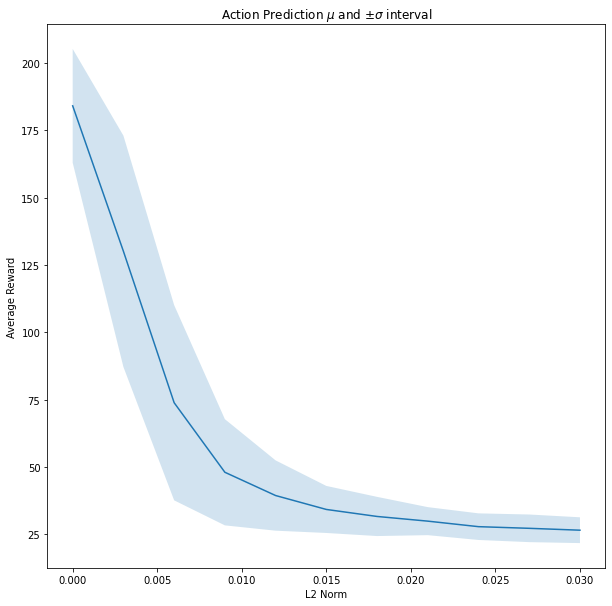

In [31]:
plot_norms(episodes)